# X-Ray

Imports


In [ ]:
# Bibliotecas estándar de Python
import os
import random
import shutil
from collections import Counter

# Bibliotecas de terceros generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image, ImageDataGenerator

# tf-explain
from tf_explain.core.grad_cam import GradCAM

# PyTorch y Torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models as models_torch


In [53]:
# Ajustar según necesidad. Si se deja automáticamente puede coger todos los núcleos de la CPU y crashear el sistema.

# Limitar a 2 núcleos de CPU
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["TF_NUM_INTEROP_THREADS"] = "16"
os.environ["TF_NUM_INTRAOP_THREADS"] = "16"

# Configurar el número de hilos en TensorFlow
tf.config.threading.set_inter_op_parallelism_threads(16)
tf.config.threading.set_intra_op_parallelism_threads(16)

### Data check

#### Clase Bacterial

Se observó que el caso de Bacterial se tenía muy pocas imágene, por lo que se decidió hacer una ejecución **balanceada** para ver cómo rendiría.

Se observó que, a pesar de que lograba clasificar bien algunas, la gran mayoría los clasificaba bajo la categoría de COVID-19.

Debido al mal rendimiento que se vio, y al deseo de darle explicabilidad a los modelos, se decidió no incluir esta clase en nuestra dataset, ya que consideramos que son ruido o outliers que pueden perturbar el rendimiento del modelo.

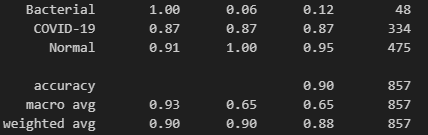

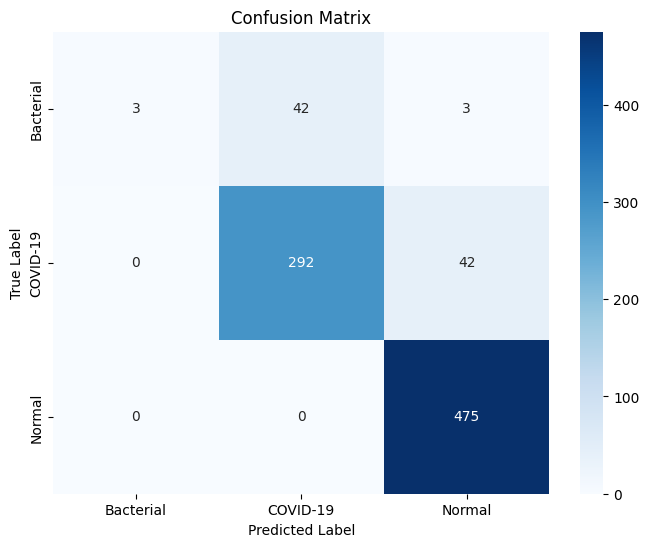

#### Data Load

In [3]:
# Rutas
dataset_path = 'data/raw/covid-chest-xray'
output_path = 'data/processed'  # Carpeta donde se guardarán las imágenes organizadas

# Crear carpetas de destino si no existen
covid_path = os.path.join(output_path, 'COVID-19')
normal_path = os.path.join(output_path, 'Normal')

os.makedirs(covid_path, exist_ok=True)
os.makedirs(normal_path, exist_ok=True)

# Diccionario para contar imágenes por categoría
folder_image_counts = {}

# Iterar sobre las carpetas dentro del dataset
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    
    if os.path.isdir(folder_path):  # Verificar si es un directorio
        all_files = os.listdir(folder_path)
        
        # Filtrar solo imágenes (png, jpg, jpeg)
        image_files = [f for f in all_files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        folder_image_counts[folder] = len(image_files)

        # Clasificar imágenes y moverlas a las carpetas correctas
        for image_file in image_files:
            source = os.path.join(folder_path, image_file)
            
            if "covid" in folder.lower():  
                dest = os.path.join(covid_path, image_file)  # Guardar en COVID-19
            elif "normal" in folder.lower():
                dest = os.path.join(normal_path, image_file)  # Guardar en Not COVID-19
            else:
                continue
            
            shutil.copy(source, dest)  # Copiar la imagen a la nueva carpeta

# Imprimir el resumen de imágenes en cada carpeta original
for folder, count in folder_image_counts.items():
    print(f"{folder}: {count} images")

# Contar imágenes en las carpetas organizadas
print(f"\nTotal imágenes en COVID-19: {len(os.listdir(covid_path))}")
print(f"Total imágenes en Not_Covid-19: {len(os.listdir(normal_path))}")

Bacterial: 48 images
COVID-19: 342 images
Normal: 486 images

Total imágenes en COVID-19: 342
Total imágenes en Not_Covid-19: 486


Ignoramos bacterial o hacemos data-augmentation para balancear las clases?


Generamos carpeta con las imagenes de train y test


In [4]:
# Path to the original dataset and output directory
dataset_path = "data/processed"
output_path = "data/split"

# Define train-test split ratio
train_ratio = 0.8

# Create train and test directories
train_path = os.path.join(output_path, "train")
test_path = os.path.join(output_path, "test")

# Ensure directories exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate through each category (subfolder)
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    # Check if it's a directory
    if os.path.isdir(category_path):
        # Create corresponding train/test subfolders
        train_category_path = os.path.join(train_path, category)
        test_category_path = os.path.join(test_path, category)
        os.makedirs(train_category_path, exist_ok=True)
        os.makedirs(test_category_path, exist_ok=True)
        
        # Get all image files
        all_images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(all_images)  # Shuffle to randomize selection

        # Split data
        train_count = int(len(all_images) * train_ratio)
        train_images = all_images[:train_count]
        test_images = all_images[train_count:]

        # Move images to respective folders
        for img in train_images:
            shutil.copy2(os.path.join(category_path, img), os.path.join(train_category_path, img))
        
        for img in test_images:
            shutil.copy2(os.path.join(category_path, img), os.path.join(test_category_path, img))

        print(f"Processed {category}: {len(train_images)} train, {len(test_images)} test")

Processed COVID-19: 273 train, 69 test
Processed Normal: 388 train, 98 test


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

Funcion para balancear las clases (inicial de bacterial)

In [6]:
# class BalancedDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, generator, batch_size):
#         """
#         Inicializa el generador balanceado.
        
#         Parámetros:
#         - generator: objeto DirectoryIterator (por ejemplo, de flow_from_directory) con shuffle=False.
#         - batch_size: tamaño del batch que se devolverá.
#         """
#         self.generator = generator
#         self.batch_size = batch_size
#         # Array con la clase (etiqueta entera) de cada muestra
#         self.classes = generator.classes  
#         # Diccionario de clases, por ejemplo: {'Bacterial': 0, 'Normal': 1, 'COVID-19': 2}
#         self.class_indices = generator.class_indices  
        
#         # Obtener índices de muestras para cada clase
#         self.indices_by_class = {}
#         for class_name, class_idx in self.class_indices.items():
#             self.indices_by_class[class_idx] = np.where(self.classes == class_idx)[0]
        
#         # Encontrar el número mínimo de muestras entre todas las clases
#         self.min_samples = min(len(idxs) for idxs in self.indices_by_class.values())
        
#         # Crear una lista de índices balanceados tomando self.min_samples de cada clase
#         balanced_indices = []
#         for class_idx, idxs in self.indices_by_class.items():
#             balanced_indices.extend(idxs[:self.min_samples])
#         self.balanced_indices = np.array(balanced_indices)
#         np.random.shuffle(self.balanced_indices)
    
#     def __len__(self):
#         # Número total de batches por época
#         return len(self.balanced_indices) // self.batch_size
    
#     def __getitem__(self, idx):
#         """
#         Devuelve un batch balanceado de imágenes y etiquetas.
        
#         Se calcula el índice individual de cada muestra y se extrae la imagen
#         y etiqueta correspondiente accediendo a la parte correcta del DirectoryIterator.
#         """
#         # Obtener los índices individuales para el batch actual
#         batch_indices = self.balanced_indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        
#         batch_images = []
#         batch_labels = []
        
#         for sample_idx in batch_indices:
#             # Determinar a qué batch del generador corresponde la muestra:
#             gen_batch_idx = sample_idx // self.generator.batch_size
#             in_batch_idx = sample_idx % self.generator.batch_size
            
#             # Obtener el batch del generador (con shuffle=False, el orden es fijo)
#             images, labels = self.generator[gen_batch_idx]
            
#             # Extraer la imagen y etiqueta individuales
#             batch_images.append(images[in_batch_idx])
#             batch_labels.append(labels[in_batch_idx])
        
#         return np.array(batch_images), np.array(batch_labels)
    


In [7]:
train_generator = train_datagen.flow_from_directory(
    'data/split/train',
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary' #class_mode='categorical' 'binary' 
)
# balanced_train_generator = BalancedDataGenerator(train_generator, batch_size=32)

Found 661 images belonging to 2 classes.


In [8]:
validation_generator = test_datagen.flow_from_directory(
    'data/split/test',
    target_size=(150, 150),
    batch_size=50,
    class_mode='binary',
    # shuffle=False
)

Found 167 images belonging to 2 classes.


## VGG16

### Cargar Modelo

In [9]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

In [10]:
for layer in conv_base.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True
    else:
        layer.trainable = False

In [11]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Arquitectura de Modelo

In [ ]:
# Create a new model and add the VGG16 base
VGG16_model = models.Sequential()
VGG16_model.add(conv_base)

# Add new layers on top of the VGG16 base
VGG16_model.add(layers.Flatten())
VGG16_model.add(layers.Dense(256, activation='relu'))
VGG16_model.add(layers.Dropout(0.2))
VGG16_model.add(layers.Dense(256, activation='relu'))
VGG16_model.add(layers.Dropout(0.2))
# model.add(layers.Dense(3, activation='softmax'))
VGG16_model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamiento

In [12]:
metrics=[
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

In [ ]:
# Compile the model
# VGG16_model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=metrics)
# model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=metrics)
VGG16_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4), metrics=metrics)

In [14]:
class_counts = train_generator.class_indices 
print(class_counts) # 0: COVID-19, 1: Normal
class_counts = {cls: len(np.where(train_generator.classes == idx)[0]) for cls, idx in class_counts.items()}
print(class_counts) # 0: COVID-19, 1: Normal

{'COVID-19': 0, 'Normal': 1}
{'COVID-19': 273, 'Normal': 388}


In [15]:
# Calcular los steps_per_epoch basados en la clase menos representada
steps_per_epoch = 32
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

# Train the model
history = VGG16_model.fit(
    train_generator,
    steps_per_epoch=50, #100
    epochs=15, #30
    validation_data=validation_generator,
    validation_steps=15,
    callbacks=[early_stop]
)

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
14/50 ━━━━━━━━━━━━━━━━━━━━ 28s 787ms/step - accuracy: 0.7699 - auc: 0.8505 - loss: 0.4534 - precision: 0.7595 - recall: 0.8837

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 290ms/step - accuracy: 0.8452 - auc: 0.9230 - loss: 0.3478 - precision: 0.8335 - recall: 0.9211 - val_accuracy: 0.9820 - val_auc: 0.9993 - val_loss: 0.0458 - val_precision: 1.0000 - val_recall: 0.9694
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.9547 - auc: 0.9921 - loss: 0.1133 - precision: 0.9614 - recall: 0.9616 - val_accuracy: 0.9880 - val_auc: 0.9997 - val_loss: 0.0403 - val_precision: 0.9800 - val_recall: 1.0000
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.9786 - auc: 0.9983 - loss: 0.0558 - precision: 0.9870 - recall: 0.9767 - val_accuracy: 0.9940 - val_auc: 0.9999 - val_loss: 0.0227 - val_precision: 0.9899 - val_recall: 1.0000
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.9847 - auc: 0.9989 - loss: 0.0429 - precision: 0.9854 - recall: 0.9883 - val_accuracy: 0.9940 - val_auc: 1.0000 - val_loss: 0.0318 - val_precision: 0.9899 - val_recall: 1.0000
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1

### Evaluación

In [16]:
history_dict = history.history

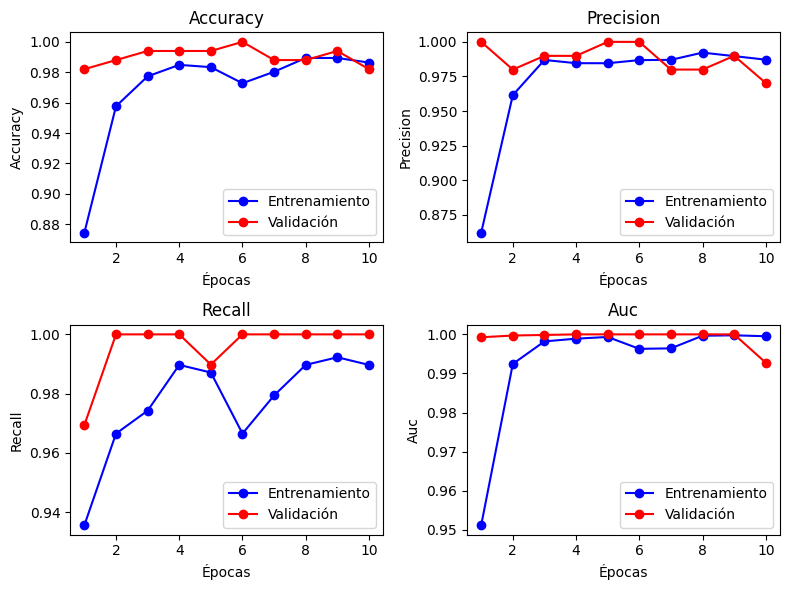

In [17]:
metric_names = ['accuracy', 'precision', 'recall', 'auc']

epochs = range(1, len(history.history['accuracy']) + 1)
n_metrics = len(metric_names)

plt.figure(figsize=(8, 6))

for i, metric in enumerate(metric_names):
    plt.subplot(2, 2, i + 1)
    # Graficar la métrica de entrenamiento
    plt.plot(epochs, history.history[metric], 'bo-', label='Entrenamiento')
    # Graficar la métrica de validación
    plt.plot(epochs, history.history['val_' + metric], 'ro-', label='Validación')
    plt.title(metric.capitalize())
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

Podemos ver que el tiene un extremadamente buen rendimiento y de manera muy consistente.

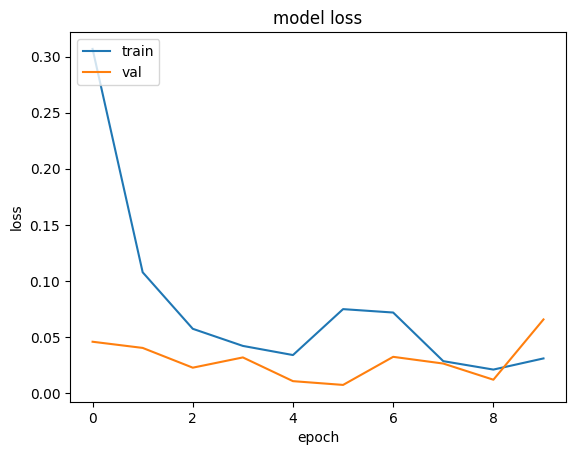

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

También vemos que la pérdida también se reduce de manera consistente y converge.

In [19]:
no_shuffle_validation_generator = test_datagen.flow_from_directory(
    'data/split/test',
    target_size=(150, 150),
    batch_size=25,
    class_mode='binary',
    shuffle=False  # Asegura que el orden de las imágenes sea el mismo
)

Found 167 images belonging to 2 classes.


In [20]:
# Obtener las etiquetas reales del conjunto de validación
y_true = no_shuffle_validation_generator.classes  # Etiquetas verdaderas en formato entero

# Calcular steps para asegurar que se procesen todas las imágenes
steps = int(np.ceil(no_shuffle_validation_generator.samples / no_shuffle_validation_generator.batch_size))

# Obtener predicciones del modelo usando el conjunto de validación
y_pred_probs = VGG16_model.predict(
    no_shuffle_validation_generator,
    steps=steps,
    verbose=1
)  # Probabilidades de salida

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step


              precision    recall  f1-score   support

    COVID-19       1.00      0.96      0.98        69
      Normal       0.97      1.00      0.98        98

    accuracy                           0.98       167
   macro avg       0.99      0.98      0.98       167
weighted avg       0.98      0.98      0.98       167

          COVID-19  Normal
COVID-19        66       3
Normal           0      98


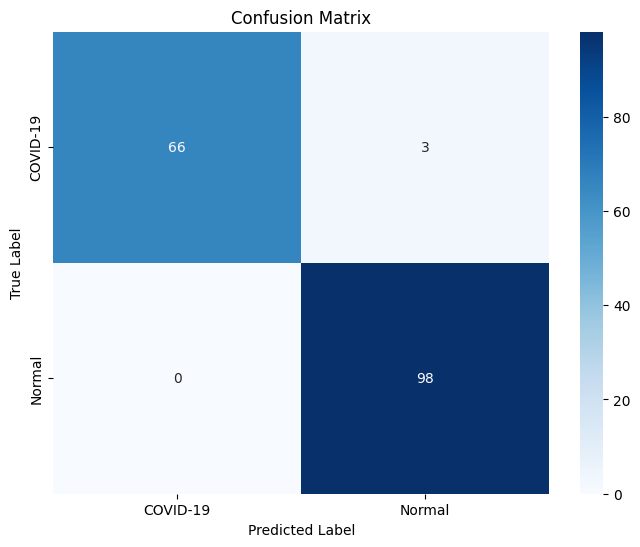

In [21]:
# Convertir probabilidades a clases predichas (solo si usas softmax)
# y_pred = np.argmax(y_pred_probs, axis=1)  # Clase con mayor probabilidad para categoricas
y_pred = (y_pred_probs > 0.5).astype(int)

# Obtener nombres de las clases
class_labels = list(no_shuffle_validation_generator.class_indices.keys())

# Generar y mostrar el classification report
report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)

# Obtener nombres de las clases
class_labels = list(validation_generator.class_indices.keys())

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión como tabla
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print(df_conf_matrix)  # Muestra los valores de la matriz

# Graficar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Podemos ver que el modelo tiene una gran capacidad de diferenciar los casos normales de los con covid-19.

# ResNet50

## Cargar el modelo ResNet50

In [23]:
# Load the ResNet50 model
conv_base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_ResNet50.trainable = True

for layer in conv_base_ResNet50.layers:
    if layer.name.startswith('conv5'):
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
conv_base_ResNet50.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 14,976,000 (57.13 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

## Importar el modelo

In [25]:
# Create a new model and add the ResNet50 base
model_ResNet50 = models.Sequential()
model_ResNet50.add(conv_base_ResNet50)

# Add new layers on top of the ResNet50 base
model_ResNet50.add(layers.Flatten())
model_ResNet50.add(layers.Dense(256, activation='relu'))
model_ResNet50.add(layers.Dropout(0.5))
# model_ResNet50.add(layers.Dense(256, activation='relu'))
# model_ResNet50.add(layers.Dropout(0.2))
model_ResNet50.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_ResNet50.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4), metrics=metrics)
# model_ResNet50.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=1e-4), metrics=metrics)

In [26]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Train the model
history_ResNet50 = model_ResNet50.fit(
    train_generator,
    steps_per_epoch=25, #100
    epochs=15, #30
    validation_data=validation_generator,
    validation_steps=15,
    # callbacks=[early_stop],
    )

Epoch 1/15
14/25 ━━━━━━━━━━━━━━━━━━━━ 6s 558ms/step - accuracy: 0.6344 - auc: 0.8457 - loss: 1.4667 - precision: 0.7972 - recall: 0.8129

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 452ms/step - accuracy: 0.6701 - auc: 0.8398 - loss: 1.2643 - precision: 0.7970 - recall: 0.8137 - val_accuracy: 0.5868 - val_auc: 0.9382 - val_loss: 0.7335 - val_precision: 0.5868 - val_recall: 1.0000
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.8763 - auc: 0.9353 - loss: 0.3186 - precision: 0.8843 - recall: 0.9063 - val_accuracy: 0.5868 - val_auc: 0.9500 - val_loss: 0.6972 - val_precision: 0.5868 - val_recall: 1.0000
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - accuracy: 0.8478 - auc: 0.9196 - loss: 0.3620 - precision: 0.8527 - recall: 0.9014 - val_accuracy: 0.5868 - val_auc: 0.9783 - val_loss: 0.6484 - val_precision: 0.5868 - val_recall: 1.0000
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.8897 - auc: 0.9593 - loss: 0.2529 - precision: 0.9032 - recall: 0.9121 - val_accuracy: 0.5868 - val_auc: 0.9823 - val_loss: 0.6169 - val_precision: 0.5868 - val_recall: 1.0000
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1

## Resultados

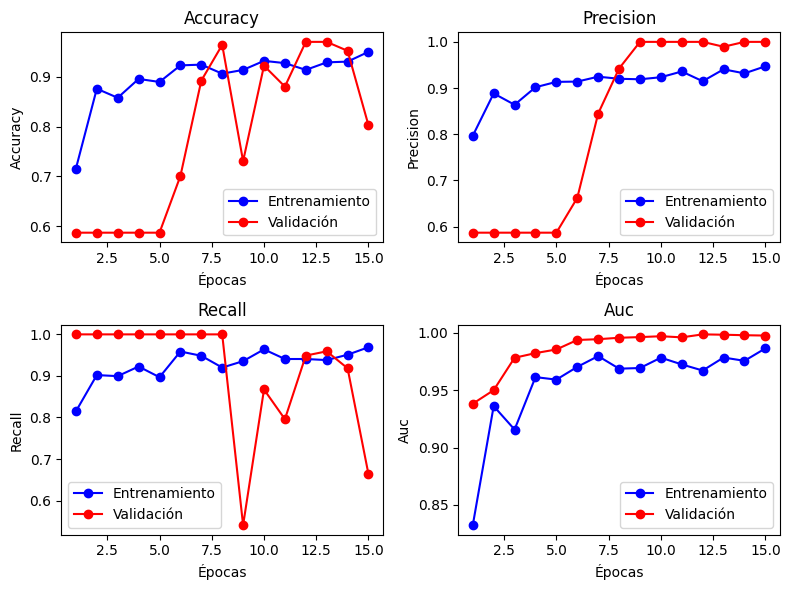

In [27]:
metric_names = ['accuracy', 'precision', 'recall', 'auc']

epochs = range(1, len(history_ResNet50.history['accuracy']) + 1)
n_metrics = len(metric_names)

plt.figure(figsize=(8, 6))

for i, metric in enumerate(metric_names):
    plt.subplot(2, 2, i + 1)
    # Graficar la métrica de entrenamiento
    plt.plot(epochs, history_ResNet50.history[metric], 'bo-', label='Entrenamiento')
    # Graficar la métrica de validación
    plt.plot(epochs, history_ResNet50.history['val_' + metric], 'ro-', label='Validación')
    plt.title(metric.capitalize())
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

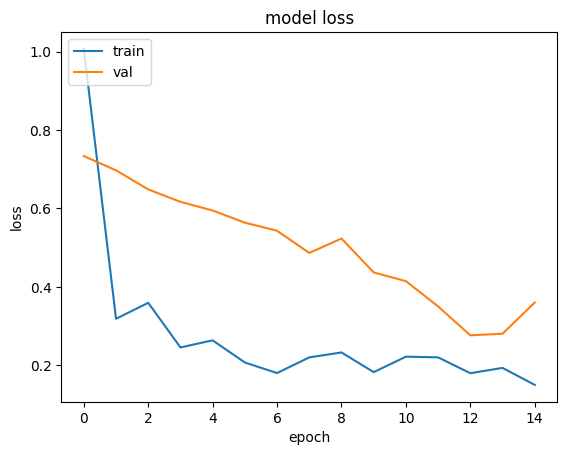

In [28]:
plt.plot(history_ResNet50.history['loss'])
plt.plot(history_ResNet50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Podemos ver que la métrica logra bajor pero no converge del todo, teniendo aun un error bastante alto. Esto podría indicar que falta mayor tiempo de entrenamiento.

In [29]:
# Obtener las etiquetas reales del conjunto de validación
y_true = no_shuffle_validation_generator.classes  # Etiquetas verdaderas en formato entero

# Calcular steps para asegurar que se procesen todas las imágenes
steps = int(np.ceil(no_shuffle_validation_generator.samples / no_shuffle_validation_generator.batch_size))

# Obtener predicciones del modelo usando el conjunto de validación
y_pred_probs_ResNet50 = model_ResNet50.predict(
    no_shuffle_validation_generator,
    steps=steps,
    verbose=10
)  # Probabilidades de salida

              precision    recall  f1-score   support

    COVID-19       0.68      1.00      0.81        69
      Normal       1.00      0.66      0.80        98

    accuracy                           0.80       167
   macro avg       0.84      0.83      0.80       167
weighted avg       0.87      0.80      0.80       167

          COVID-19  Normal
COVID-19        69       0
Normal          33      65


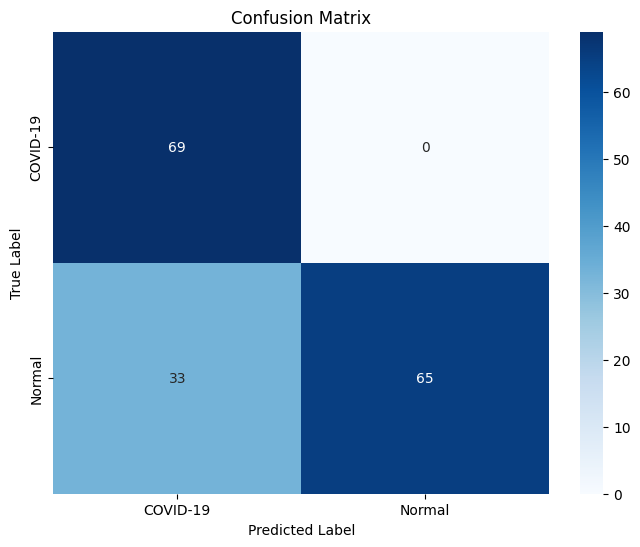

In [30]:
# Convertir probabilidades a clases predichas (solo si usas softmax)
# y_pred_ResNet50 = np.argmax(y_pred_probs, axis=1)  # Clase con mayor probabilidad para categoricas
y_pred_ResNet50 = (y_pred_probs_ResNet50 > 0.5).astype(int)

# Obtener nombres de las clases
class_labels = list(no_shuffle_validation_generator.class_indices.keys())

# Generar y mostrar el classification report
report = classification_report(y_true, y_pred_ResNet50, target_names=class_labels)

print(report)

# Obtener nombres de las clases
class_labels = list(validation_generator.class_indices.keys())

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_ResNet50)

# Mostrar la matriz de confusión como tabla
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
print(df_conf_matrix)  # Muestra los valores de la matriz

# Graficar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Se ve que tiene una alta sensibilidad para los casos de covid, sin embargo, se confunde con los casos normales.

# AlexNet

In [31]:
data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=10),            # Rotación aleatoria de hasta 5° (pequeños ajustes)
    transforms.RandomHorizontalFlip(),               # Volteo horizontal aleatorio (si es clínicamente válido)
    transforms.Resize(256),              # Redimensiona la imagen para mantener la relación de aspecto.
    transforms.RandomResizedCrop(227),          # Recorta la imagen al tamaño esperado por AlexNet (227×227).
    transforms.Grayscale(num_output_channels=3),       # Si las imágenes son en escala de grises, convertir a 3 canales
    transforms.ToTensor(),               # Convierte a tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),                          # Redimensiona la imagen
    transforms.Grayscale(num_output_channels=3),       # Si las imágenes son en escala de grises, convertir a 3 canales
    transforms.ToTensor(),                           # Convierte a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


### Datos

In [32]:
data_dir = 'data/split/'
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=data_transforms)
test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=25, shuffle=False)

## Cargar AlexNet

In [33]:
model_AlexNet = models_torch.alexnet(pretrained=True)

# Primero, congelamos todas las capas convolucionales:
for param in model_AlexNet.features.parameters():
    param.requires_grad = False

# Luego, descongelamos la última capa convolucional, que en este ejemplo es la que está en el índice 10:
for param in model_AlexNet.features[10].parameters():
    param.requires_grad = True

model_AlexNet.classifier[6] = nn.Linear(4096, 1)

model_AlexNet = model_AlexNet.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_AlexNet.parameters(), lr=0.005)

## Entrenar modelo

In [35]:
model_AlexNet.train()
hist_loss = []
hist_accuracy = []
epochs = 15

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model_AlexNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = torch.round(torch.sigmoid(outputs))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    hist_loss.append(epoch_loss)
    hist_accuracy.append(epoch_acc)
    
    print(f'Epoch {epoch+1}/15 - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}')

Epoch 1/15 - Loss: 33.4382 - Accuracy: 0.6172
Epoch 2/15 - Loss: 0.3178 - Accuracy: 0.8835
Epoch 3/15 - Loss: 0.3632 - Accuracy: 0.9153
Epoch 4/15 - Loss: 0.2286 - Accuracy: 0.9259
Epoch 5/15 - Loss: 0.1720 - Accuracy: 0.9592
Epoch 6/15 - Loss: 0.2400 - Accuracy: 0.9334
Epoch 7/15 - Loss: 0.1065 - Accuracy: 0.9697
Epoch 8/15 - Loss: 0.2087 - Accuracy: 0.9576
Epoch 9/15 - Loss: 0.2352 - Accuracy: 0.9561
Epoch 10/15 - Loss: 0.2299 - Accuracy: 0.9259
Epoch 11/15 - Loss: 0.1473 - Accuracy: 0.9561
Epoch 12/15 - Loss: 0.1699 - Accuracy: 0.9531
Epoch 13/15 - Loss: 0.1753 - Accuracy: 0.9425
Epoch 14/15 - Loss: 0.4270 - Accuracy: 0.9425
Epoch 15/15 - Loss: 0.1877 - Accuracy: 0.9395


## Resultados

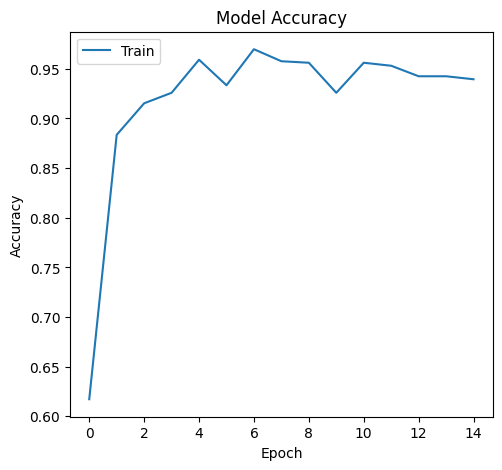

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_accuracy)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

plt.show()

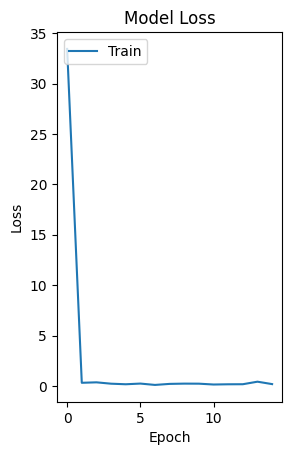

In [37]:
plt.subplot(1,2,2)
plt.plot(hist_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

plt.show()

In [38]:
model_AlexNet.eval()  # Pone el modelo en modo evaluación
val_loss = 0.0
correct_val = 0
total_val = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model_AlexNet(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        # Para clasificación binaria: usamos sigmoid y redondeamos
        predicted = torch.round(torch.sigmoid(outputs))
        correct_val += (predicted == labels).sum().item()
        total_val += labels.size(0)

# Promedio de loss y accuracy en el conjunto de validación
val_loss = val_loss / len(test_loader)
val_acc = correct_val / total_val

print(f'Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}')

Validation Loss: 0.1623 - Validation Accuracy: 0.9281


## Explainability

En este apartado buscamos darle explicabilidad a la información que utiliza el modelo para realizar las predicciones. Para ello, utilizaremos Grad CAM, una técnica que utiliza los gradientes de las últimas capas convolucionales para generar mapas de calor, resaltando las áreas de una imagen que más influyen en la predicción del modelo.

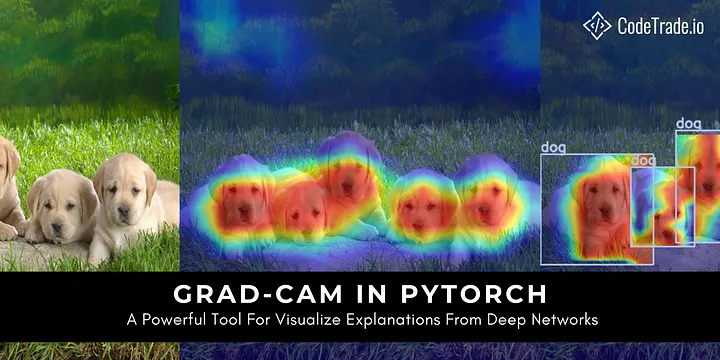

*CodeTrade India. Grad-CAM In PyTorch: A Powerful Tool For Visualize Explanations From Deep Networks. Medium*



Utilizaremos el modelo VGG16, que ha sido el modelo con mejores rendimientos y con mayor estabilidad.

In [39]:
base_vgg = VGG16_model.get_layer('vgg16')
# target_layer = base_vgg.get_layer('block5_conv1')
# print(target_layer.name)


Función para cargar las imagenes

In [40]:
# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normaliza si es necesario
    return img_array

In [41]:
def recolect_imgs(directories, n_images_per_dir=3, target_size=(150, 150)):
    # Recolectar N imágenes de cada directorio
    images_info = []  # Lista de tuplas: (directorio, ruta_completa, img_array)
    for d in directories:
        # Listar archivos de imagen (jpg, jpeg, png)
        files = [f for f in os.listdir(d) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        files.sort()  # Ordena para mantener consistencia
        selected_files = files[:n_images_per_dir]
        for f in selected_files:
            full_path = os.path.join(d, f)
            img_array = load_and_preprocess_image(full_path, target_size)
            images_info.append((d, full_path, img_array))
    return images_info

Función para graficar las imágenes con las distintas capas de convolución

In [42]:
def plot_Grad_CAM(images_info, layers_to_explain, class_index, explainer, base_vgg):
    for dir_name, img_path, img_array in images_info:
        n_layers = len(layers_to_explain)
        total_columns = n_layers + 1  # 1 columna adicional para la imagen original
        fig, axes = plt.subplots(1, total_columns, figsize=(5 * total_columns, 5))
        fig.suptitle(f"Imagen original y Grad-CAM para {os.path.basename(img_path)}\nfrom {dir_name}", fontsize=14)
        
        # Mostrar la imagen original (asumiendo que img_array está preprocesada y normalizada entre 0 y 1)
        # Se elimina la dimensión de batch:
        orig_img = img_array[0]
        axes[0].imshow(orig_img)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        # Para cada capa, generar Grad-CAM y mostrarlo
        for i, layer_name in enumerate(layers_to_explain):
            grid = explainer.explain((img_array, None), base_vgg, class_index=class_index, layer_name=layer_name)
            axes[i+1].imshow(grid)
            axes[i+1].set_title(layer_name)
            axes[i+1].axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


Aquí le pasamos los directorios y las capas que queremos analizar.

In [50]:
# directories_covid = ['data/split/train/COVID-19', 'data/split/test/COVID-19']  
# directories_normal = ['data/split/train/Normal', 'data/split/test/Normal']  
directories_covid = ['data/split/test/COVID-19']  
directories_normal = ['data/split/test/Normal']  

# Lista de capas de las cuales queremos obtener Grad-CAM (debe coincidir con los nombres de las capas en base_vgg)
layers_to_explain = ['block5_conv1', 'block5_conv2', 'block5_conv3']

# Inicializar el explainer de Grad-CAM
explainer = GradCAM()

In [51]:
imgs_cov = recolect_imgs(directories_covid, 1)
imgs_norm = recolect_imgs(directories_normal, 1)

c:\Users\NoobG\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


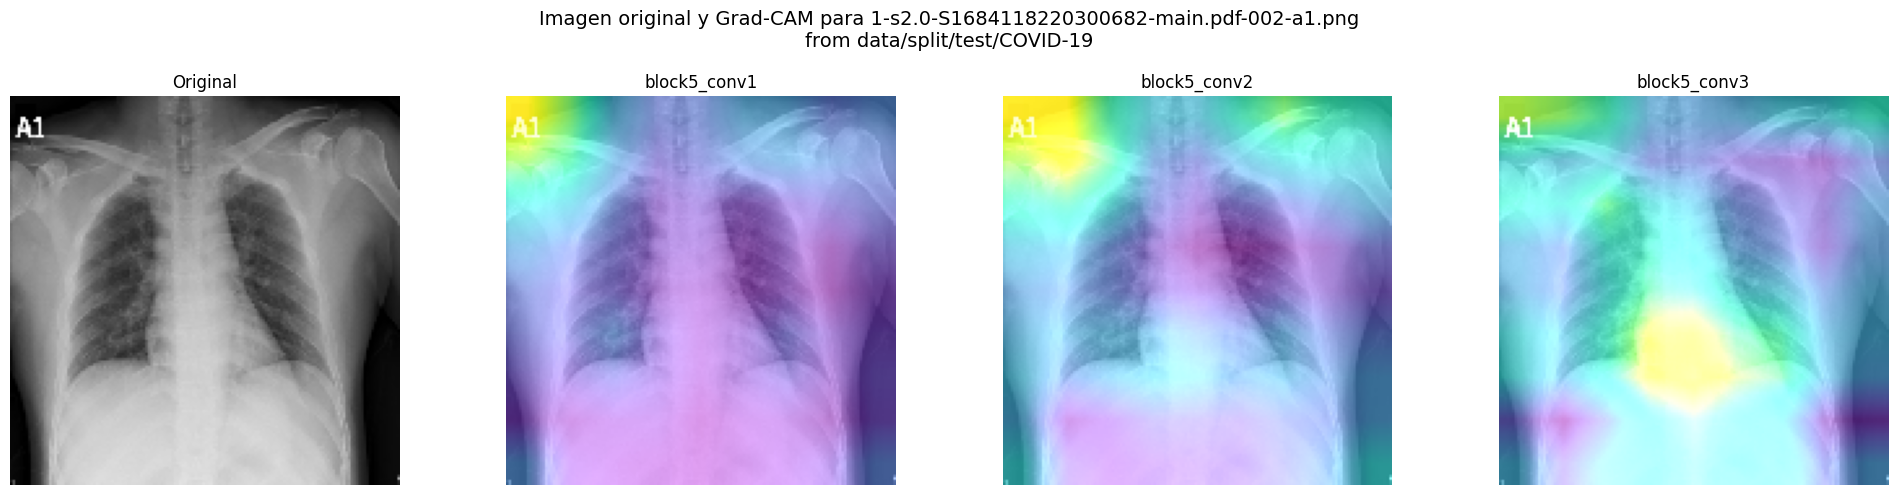

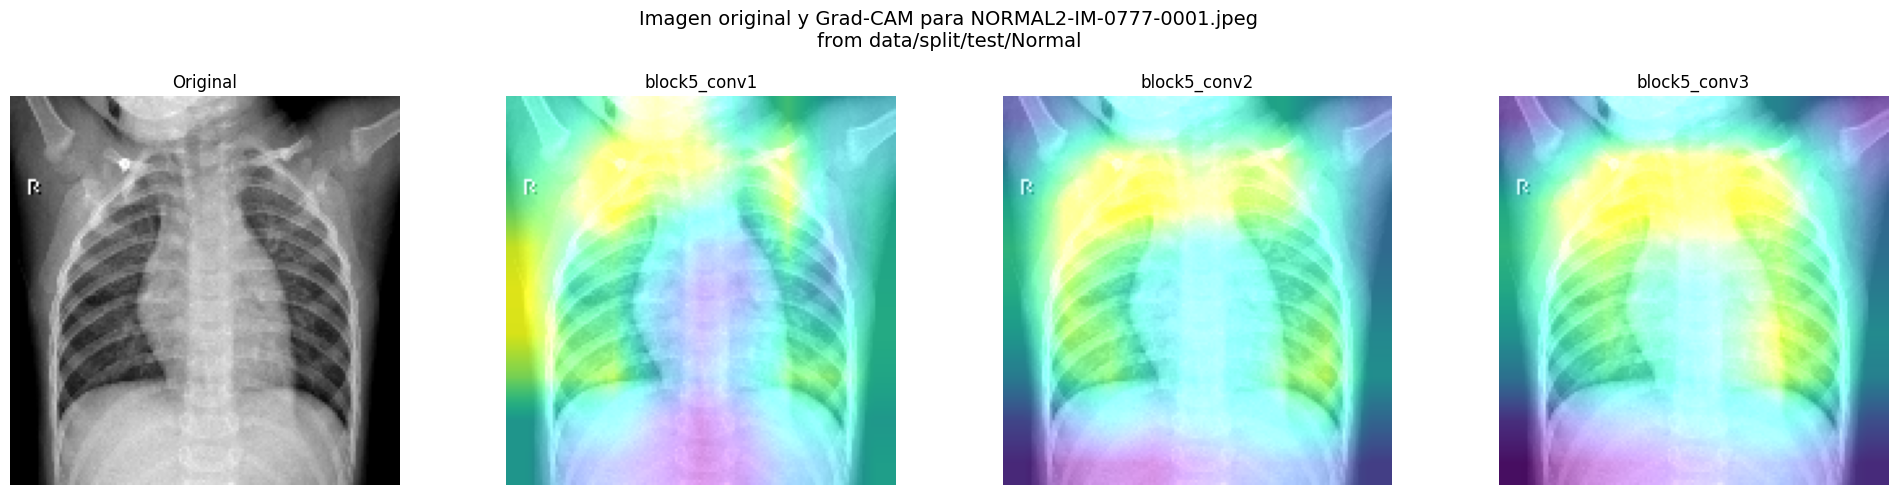

In [52]:
plot_Grad_CAM(imgs_cov, layers_to_explain, class_index=0, explainer=explainer, base_vgg=base_vgg)
plot_Grad_CAM(imgs_norm, layers_to_explain, class_index=1, explainer=explainer, base_vgg=base_vgg)

Si analizamos detalladamente las mapas de activación, podemos observar que 

#### COVID-19 Cases

Si analizamos los outputs de Grad CAM de manera detallada, podemos observar, que en caso del covid, las capas de convolución 1 y 2 prestan gran atención en los textos que aparecen en las radiografías. Esto nos indica que puede ser que existan fuga de datos relacionado a los textos que aparecen en estas radiografías.

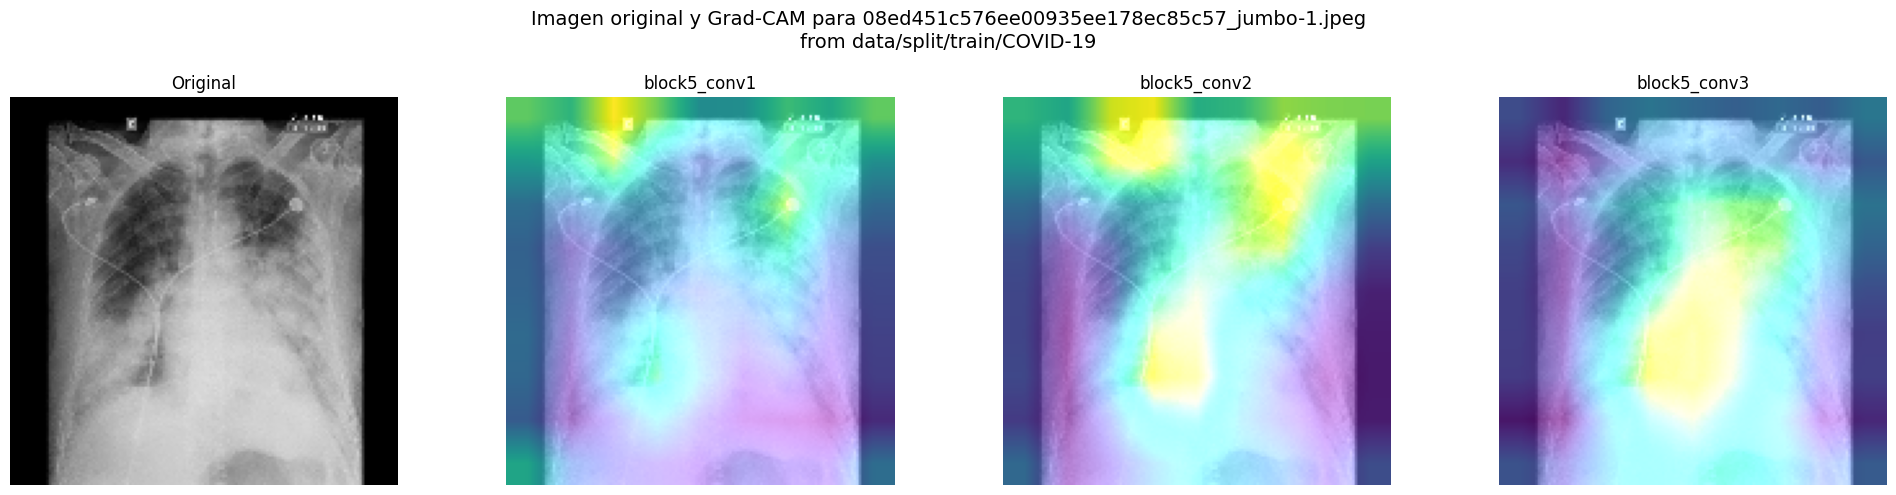
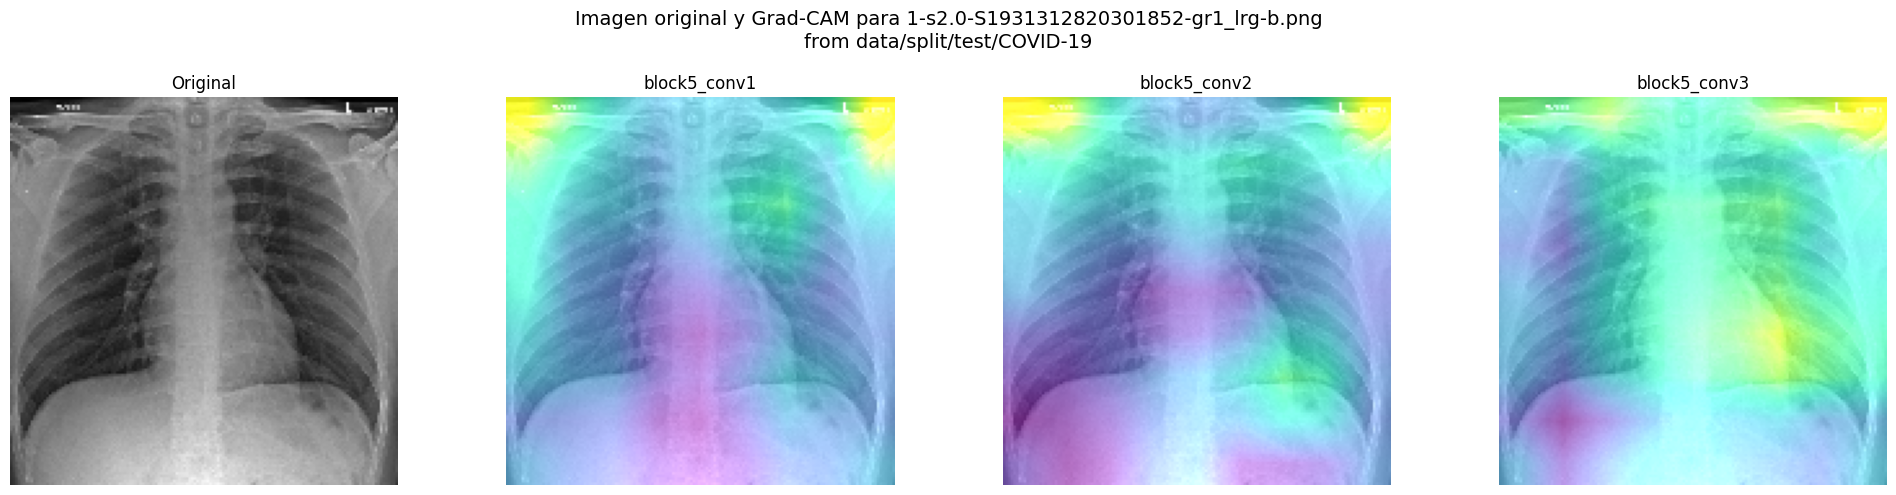

Por Otro lado, si Nos ponemos a analizar de manera detallada los casos de Normal, podemos ver que éstas, se centran más en los pulmones, a pesar de que las capas de convolución superiores miren también en esquinas, lo que se sospecha que puede estar mirando por la ausencia de estos textos. Sin embargo, si que se ve que se centran primariamente en la zona de los pulmones, sobre todo en las capas de convoluciones 2 y 3.

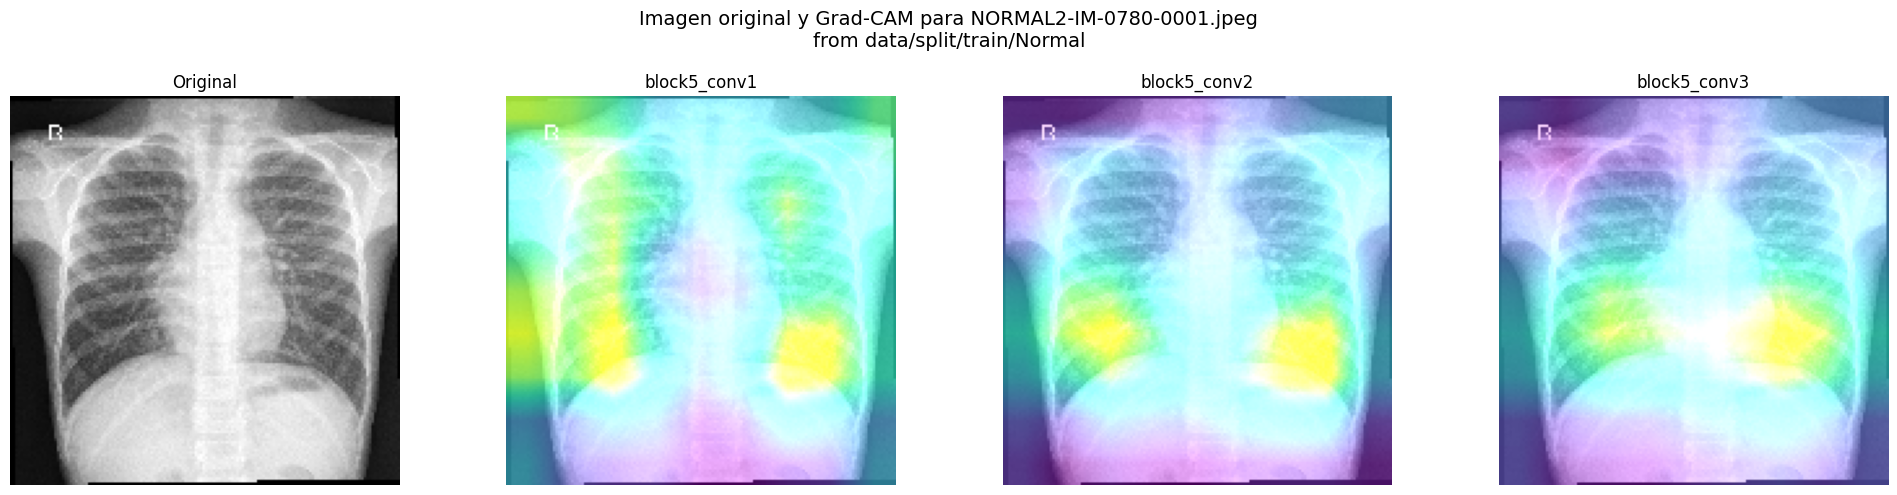
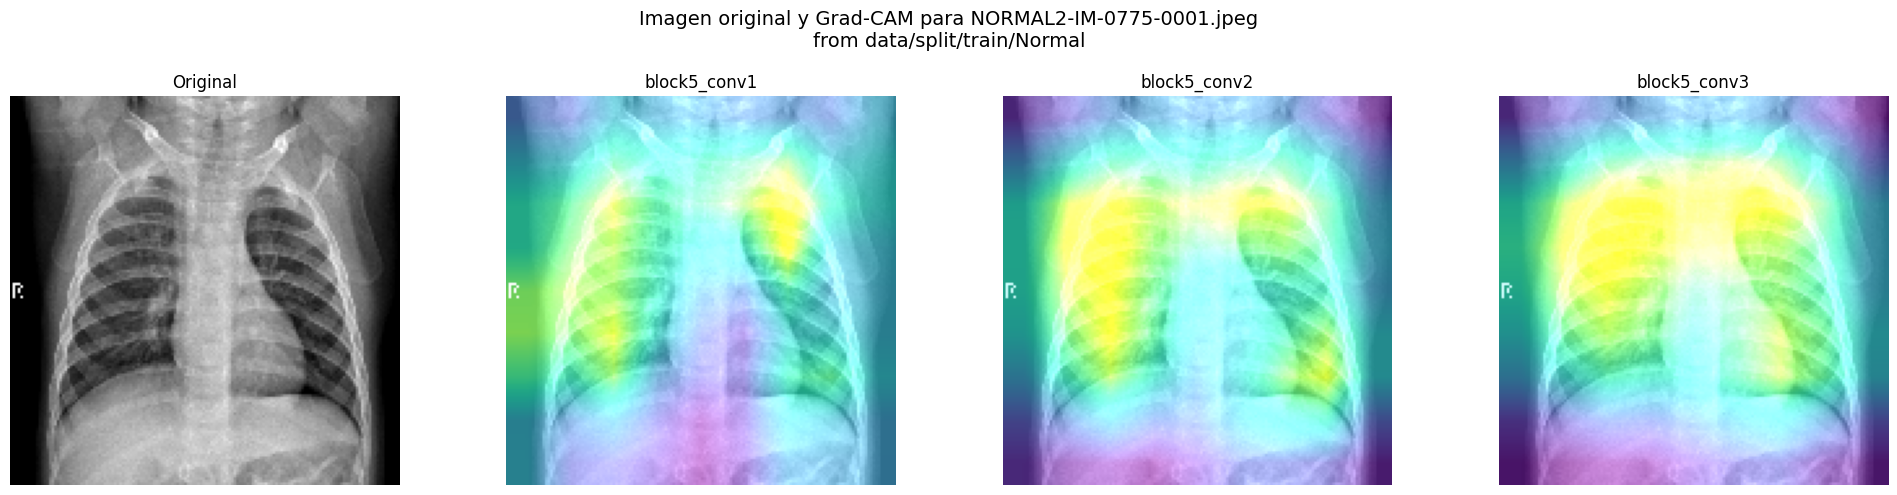